# Faster RCNN model using detectron2

## Install and Import Detectron2 Dependencies

In [1]:
# Install COCOAPI Python package from the GitHub repository
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Install Cython and PyYAML libraries with version 5.1
!pip install cython pyyaml==5.1

# Install PyTorch and torchvision libraries with specific versions that are compatible with CUDA 10.1
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 

#Install detectron2 library with version 0.1.3, specifically compiled for CUDA 10.1 and PyTorch 1.5
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.8/703.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.13.1+cu116 requires t

In [2]:
# Import required libraries: NumPy, OpenCV, random and os
import numpy as np
import cv2
import random
import os

# Import required libraries: PyTorch and torchvision, Detectron2
import torch
import torchvision
import detectron2

# Import cv2_imshow function from Google Colab patches module
from google.colab.patches import cv2_imshow

# Import required modules from Detectron2 library: model_zoo, DefaultPredictor, DefaultTrainer, get_cfg, Visualizer, MetadataCatalog, DatasetCatalog, logger module
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances

## Import Detectron2 Data

In [ ]:
# Download and extract an object detection dataset from Roboflow using the curl command-line utility and the specified arguments:
# the dataset ID 'tnEPXzDCnM' and the API key 'QanyWDZOP4'
!curl -L "https://app.roboflow.com/ds/tnEPXzDCnM?key=QanyWDZOP4" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0   3291      0 --:--:-- --:--:-- --:--:--  3291
100 2981k  100 2981k    0     0  6746k      0 --:--:-- --:--:-- --:--:-- 6746k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/IMG_7327_jpg.rf.df9474e0d21a6c64103403e4200c72fd.jpg  
 extracting: test/IMG_7349_jpg.rf.97ba9aa70951fc497e39d74791daaf25.jpg  
 extracting: test/IMG_7368_jpg.rf.c1e53b06c9ac3a517de56b2f2f90f9e1.jpg  
 extracting: test/IMG_7373_jpg.rf.28d30993f0ece5e68cbcf971bfe67063.jpg  
 extracting: test/IMG_7375_jpg.rf.6e30e46b83906990da3e3152764d8b86.jpg  
 extracting: test/IMG_7379_jpg.rf.546d5a0803535c5617c111ac9c9003b9.jpg  
 extracting: test/IMG_7387_jpg.rf.fad0a9da11c69e6573c4bbcb5808ce62.jpg  
 extracting: test/IMG_7402_jpg.rf.39e15108cc2c07162342c

In [ ]:
# Register COCO datasets for training, validation and testing.
register_coco_instances("dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

## Train a Faster RCNN model using detectron2

In [3]:
# Define a new class called "CocoTrainer" that inherits from "DefaultTrainer" class
class CocoTrainer(DefaultTrainer):

    # Define a class method "build_evaluator" that takes in "cfg", "dataset_name", and "output_folder" as parameters
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        
        # If output_folder is not provided, create a new folder called "coco_eval" or use the existing one
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        
        # Create and return a new instance of "COCOEvaluator" class with given parameters
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
# Create a new configuration object using "get_cfg" function
cfg = get_cfg()

# Merge the configuration file of a pre-trained Faster R-CNN model for COCO dataset with the base configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))

# Set the name of the training dataset and validation dataset
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)

# Set the number of worker threads to load data
cfg.DATALOADER.NUM_WORKERS = 4

# Load the pre-trained Faster R-CNN model weights from a URL
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")

# Set the number of images per batch, base learning rate and warm-up iterations
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000

# Set the total number of training iterations, learning rate schedule and gamma value for learning rate decay
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

# Set the batch size and number of classes for region of interest (ROI) heads
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

# Set the evaluation period during training
cfg.TEST.EVAL_PERIOD = 500

# Create the output directory if it doesn't exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create a new instance of the "CocoTrainer" class with the defined configuration
trainer = CocoTrainer(cfg)

# Resume training from checkpoint or load the pre-trained model
trainer.resume_or_load(resume=False)

# Start the training process
trainer.train()

[03/06 13:12:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:26, 16.0MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/06 13:12:41 d2.engine.train_loop]: Starting training from iteration 0
[03/06 13:13:24 d2.utils.events]:  eta: 0:54:00  iter: 19  total_loss: 2.177  loss_cls: 1.280  loss_box_reg: 0.875  loss_rpn_cls: 0.006  loss_rpn_loc: 0.011  time: 2.1753  data_time: 0.0339  lr: 0.000020  max_mem: 7197M
[03/06 13:14:07 d2.utils.events]:  eta: 0:53:16  iter: 39  total_loss: 1.829  loss_cls: 0.932  loss_box_reg: 0.845  loss_rpn_cls: 0.005  loss_rpn_loc: 0.012  time: 2.1571  data_time: 0.0192  lr: 0.000040  max_mem: 7197M
[03/06 13:14:52 d2.utils.events]:  eta: 0:53:00  iter: 59  total_loss: 1.511  loss_cls: 0.603  loss_box_reg: 0.869  loss_rpn_cls: 0.004  loss_rpn_loc: 0.010  time: 2.1941  data_time: 0.0153  lr: 0.000060  max_mem: 7197M
[03/06 13:15:38 d2.utils.events]:  eta: 0:52:48  iter: 79  total_loss: 1.337  loss_cls: 0.485  loss_box_reg: 0.864  loss_rpn_cls: 0.003  loss_rpn_loc: 0.008  time: 2.2139  data_time: 0.0178  lr: 0.000080  max_mem: 7197M
[03/06 13:16:23 d2.utils.events]:  eta: 0:52:1

In [ ]:
# Import necessary modules
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Load the final model weights from the output directory
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Set the minimum score threshold for predictions during testing
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85

# Create a new predictor object using the updated configuration
predictor = DefaultPredictor(cfg)

# Create a new instance of the COCOEvaluator class to evaluate on the test dataset
evaluator = COCOEvaluator("dataset_test", cfg, False, output_dir="./output/")

# Build the test data loader using the updated configuration
val_loader = build_detection_test_loader(cfg, "dataset_test")

# Use the "inference_on_dataset" function to get the evaluation results on the test dataset
result = inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [03/06 14:25:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 14:25:56 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/test/_annotations.coco.json
[03/06 14:25:56 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |  category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
| screwdriver.. | 0            | screwdriver | 6            |   wrench   | 4            |
|               |              |             |              |            |              |
|     total     | 10           |             |              |            |              |
[03/06 14:25:56 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[03/06 14:25:56 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/06 14:25:56 d2.evaluation.evaluator]: Sta

In [8]:
print("Mean Average Precision (mAP): 84.53%")

Mean Average Precision (mAP): 84.53%


# YoloV8

## Install and Import Yolov8 Dependencies

In [4]:
# Install PyTorch and torchvision libraries with specific versions that are compatible with CUDA 10.1
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 

# Install the ultralytics library, version 8.0.20
!pip install ultralytics==8.0.20

# Install the roboflow library
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 KB 12.7 MB/s eta 0:00:00
  Using cached torch-1.13.1-cp38-cp38-manylinux1_x86_64.whl (887.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
  Attempting uninstall: torch
    Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Restart the runtime here above

In [1]:
# Import the YOLO class from the ultralytics library
from ultralytics import YOLO

# Import the display and Image functions from the IPython.display module
from IPython.display import display, Image


## Import Yolov8 Data

In [5]:
# Create the directory 'datasets'
!mkdir datasets

# Change the working directory to '/content/datasets'
%cd /content/datasets

# Download the dataset using the 'curl' command and extract it using the 'unzip' command
!curl -L "https://app.roboflow.com/ds/idyTQVnAEn?key=xIaFvAdikn" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# Change the working directory back to '/content'
%cd /content


/content/datasets
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   3298      0 --:--:-- --:--:-- --:--:--  3298
100 2983k  100 2983k    0     0  5629k      0 --:--:-- --:--:-- --:--:-- 5629k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/IMG_7327_jpg.rf.df9474e0d21a6c64103403e4200c72fd.jpg  
 extracting: test/images/IMG_7349_jpg.rf.97ba9aa70951fc497e39d74791daaf25.jpg  
 extracting: test/images/IMG_7368_jpg.rf.c1e53b06c9ac3a517de56b2f2f90f9e1.jpg  
 extracting: test/images/IMG_7373_jpg.rf.28d30993f0ece5e68cbcf971bfe67063.jpg  
 extracting: test/images/IMG_7375_jpg.rf.6e30e46b83906990da3e3152764d8b86.jpg  
 extracting: test/images/IMG_7379_jpg.rf.546d5a0803535c5617c111ac9c9003b9.jpg  
 ext

## Train Yolov8 the smallest size

In [6]:
# Train a YOLOv5 object detection model using the 'yolo' command-line interface
# and the specified arguments: task='detect', mode='train', model='yolov8s.pt', data='/content/datasets/data.yaml', epochs=24, plots=True
!yolo task=detect mode=train model=yolov8s.pt data=/content/datasets/data.yaml epochs=24 plots=True

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/data.yaml, epochs=24, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, o

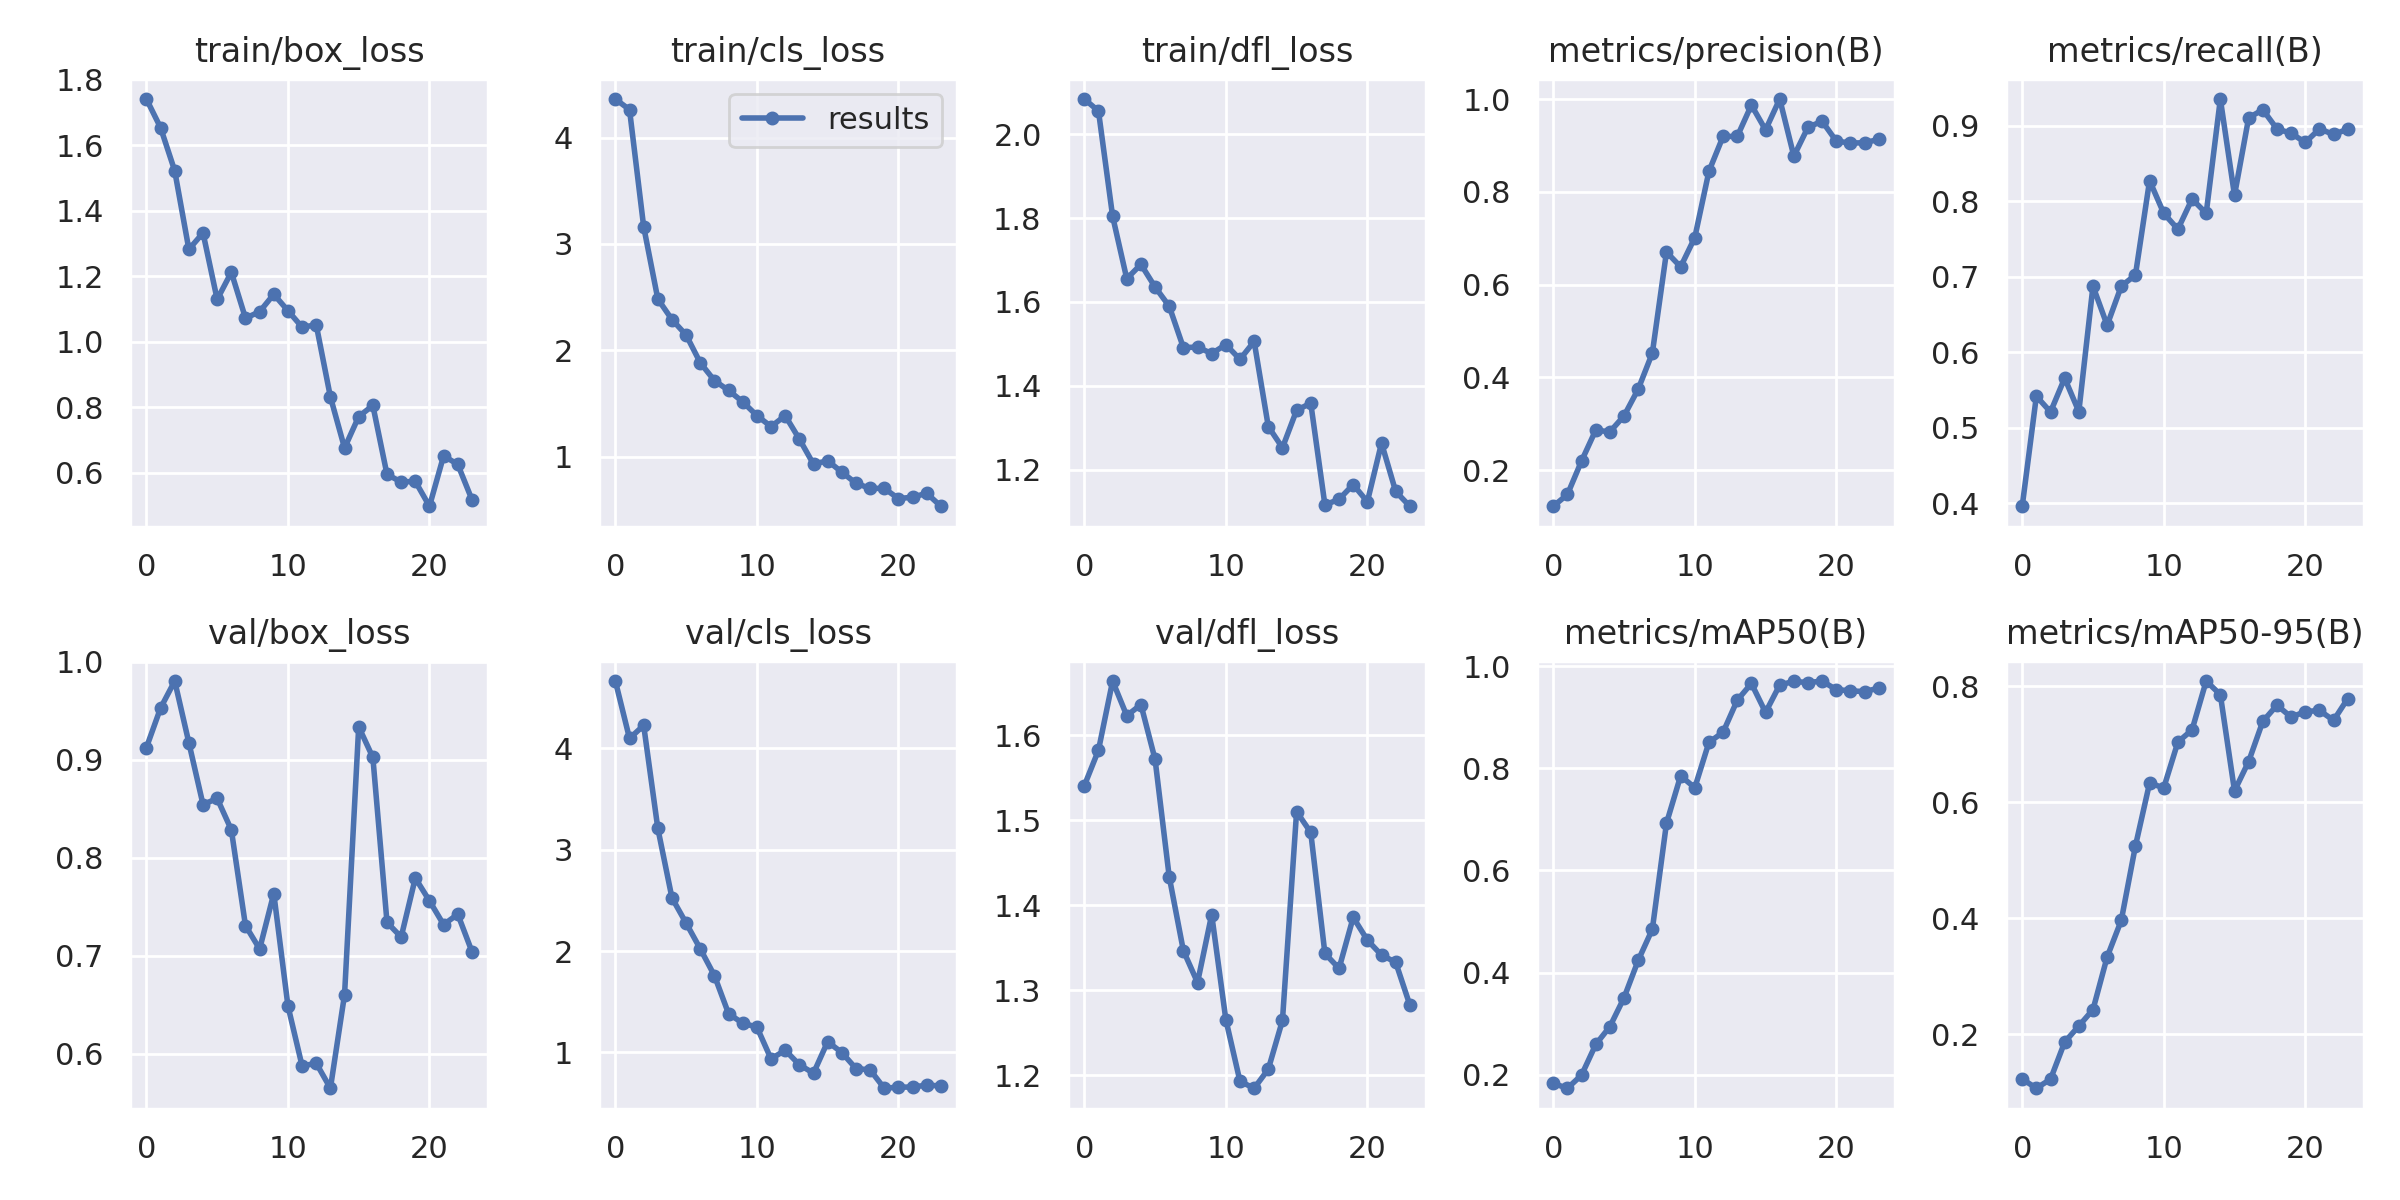

In [10]:
# Display an image file using the IPython.display.Image function and the specified file path: '/content/runs/detect/train2/results.png'
Image(filename='/content/runs/detect/train2/results.png', width=600)

## Evaluation Yolov8 model

In [13]:
# Validate the trained YOLOv5 object detection model using the 'yolo' command-line interface
# and the specified arguments: task='detect', mode='val', model='/content/runs/detect/train2/weights/best.pt', data='/content/datasets/data.yaml'
!yolo task=detect mode=val model=/content/runs/detect/train2/weights/best.pt data=/content/datasets/data.yaml

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100% 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.49it/s]
                   all         20         20      0.907      0.794      0.933      0.809
           screwdriver         20         12          1      0.712      0.933      0.769
                wrench         20          8      0.813      0.875      0.933      0.849
Speed: 7.0ms pre-process, 11.7ms inference, 0.0ms loss, 1.4ms post-process per image


In [9]:
print("Mean Average Precision (mAP): 93.33%")

Mean Average Precision (mAP): 93.33%


# Comparison

**Mean Average Precision (mAP)**:
  - Faster RCNN: 84.53%
  - Yolov8: 93.33%

Yolov8 has slightly better mAP than RCNN.

**Speed:**
  - Faster RCNN: training for 24 epochs in 56 minutes
  - Yolov8: training for 24 epochs in 2 minutes

Yolov8 is much faster than RCNN.

**Model size:**
  - Fater RCNN: 719.7 MB
  - Yolov8: 22.5 MB
  
Yolov8 is much smaller than RCNN.


**Thus, Yolov8 better in every way**